In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define paths
zip_path = "datazip.zip"  
extract_path = "/mnt/data/air_quality_data"  # Folder where files will be extracted

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")


Files extracted to: /mnt/data/air_quality_data


In [2]:


folder_path = "/mnt/data/air_quality_data"  # Path where your files were extracted
files = os.listdir(folder_path)  # List all files in the folder
print("Files found:", files)


Files found: ['data']


In [3]:


data_path = os.path.join(folder_path, "data")

if os.path.isdir(data_path):
    print(f"'data' is a folder. Listing contents: {os.listdir(data_path)}")
else:
    print(f"'data' is a file.")


'data' is a folder. Listing contents: ['borivali-east mpcb, mumbai-air-quality.csv', 'borivali-east, mumbai-air-quality.csv', 'chakala-andheri-east, mumbai-air-quality.csv', 'chhatrapati-shivaji intl. airport (t2), mumbai-air-quality.csv', 'colaba,-mumbai-air-quality.csv', 'deonar,-mumbai-air-quality.csv', 'kandivali-east, mumbai-air-quality.csv', 'khadakpada,-kalyan-air-quality.csv', 'khindipada-bhandup-west, mumbai-air-quality.csv', 'kurla,-mumbai-air-quality.csv', 'mahape,-navi mumbai-air-quality.csv', 'malad-west, mumbai-air-quality.csv', 'mazgaon,-mumbai-air-quality.csv', 'mulund-west, mumbai-air-quality.csv', 'powai,-mumbai-air-quality.csv', 'siddharth-nagar-worli, mumbai-air-quality.csv', 'sion,-mumbai-air-quality.csv', 'vasai-west, mumbai-air-quality.csv', 'vile-parle west, mumbai-air-quality.csv']


In [4]:



# Define the correct folder path
folder_path = "/mnt/data/air_quality_data/data"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
print(f"Found {len(csv_files)} CSV files.")

# Read and merge all CSVs
dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    try:
        df = pd.read_csv(file_path)
        df["Source_File"] = file  # Add column to track source
        dfs.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Concatenate all dataframes
if dfs:
    merged_df = pd.concat(dfs, ignore_index=True)
    print("Merging complete. Saving to file...")

    # Save merged dataset
    merged_csv_path = "/mnt/data/merged_air_quality.csv"
    merged_df.to_csv(merged_csv_path, index=False)

    print(f"✅ Merged data saved at: {merged_csv_path}")
else:
    print("❌ No data was merged.")


Found 19 CSV files.
Merging complete. Saving to file...
✅ Merged data saved at: /mnt/data/merged_air_quality.csv


In [5]:


merged_csv_path = "/mnt/data/merged_air_quality.csv"
df = pd.read_csv(merged_csv_path)

print(df.head())  # Display first 5 rows
print(df.info())  # Check data types & missing values


       date  pm25  pm10  o3  no2  so2  co  \
0  2025/3/1    92    69        8    6   1   
1  2025/3/2    83    59        8    5   1   
2  2025/3/3    80              6            
3  2025/3/4    84                           
4  2025/2/1    77    67        7    4   1   

                                  Source_File  
0  borivali-east mpcb, mumbai-air-quality.csv  
1  borivali-east mpcb, mumbai-air-quality.csv  
2  borivali-east mpcb, mumbai-air-quality.csv  
3  borivali-east mpcb, mumbai-air-quality.csv  
4  borivali-east mpcb, mumbai-air-quality.csv  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27798 entries, 0 to 27797
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         27798 non-null  object
 1    pm25        27798 non-null  object
 2    pm10        27798 non-null  object
 3    o3          27798 non-null  object
 4    no2         27798 non-null  object
 5    so2         26818 non-null  object
 6   

In [6]:
print(df)

             date  pm25  pm10  o3  no2  so2  co  \
0        2025/3/1    92    69        8    6   1   
1        2025/3/2    83    59        8    5   1   
2        2025/3/3    80              6            
3        2025/3/4    84                           
4        2025/2/1    77    67        7    4   1   
...           ...   ...   ...  ..  ...  ...  ..   
27793  2024/10/14                   12    3   6   
27794   2020/4/10                    1    6   3   
27795   2020/4/11                    2    6   3   
27796   2020/4/12                    2    6   3   
27797   2020/4/13                    4    6   3   

                                      Source_File  
0      borivali-east mpcb, mumbai-air-quality.csv  
1      borivali-east mpcb, mumbai-air-quality.csv  
2      borivali-east mpcb, mumbai-air-quality.csv  
3      borivali-east mpcb, mumbai-air-quality.csv  
4      borivali-east mpcb, mumbai-air-quality.csv  
...                                           ...  
27793     vile-parle we

In [7]:
def extract_station_name(filename):
    filename = filename.replace("-"," ")
    filename = filename.split(",")[0]
    return filename.strip().title()

df['Station_Name'] = df['Source_File'].apply(extract_station_name)

print(df['Station_Name'].unique())
    

['Borivali East Mpcb' 'Borivali East' 'Chakala Andheri East'
 'Chhatrapati Shivaji Intl. Airport (T2)' 'Colaba' 'Deonar'
 'Kandivali East' 'Khadakpada' 'Khindipada Bhandup West' 'Kurla' 'Mahape'
 'Malad West' 'Mazgaon' 'Mulund West' 'Powai' 'Siddharth Nagar Worli'
 'Sion' 'Vasai West' 'Vile Parle West']


In [8]:
print(df)

             date  pm25  pm10  o3  no2  so2  co  \
0        2025/3/1    92    69        8    6   1   
1        2025/3/2    83    59        8    5   1   
2        2025/3/3    80              6            
3        2025/3/4    84                           
4        2025/2/1    77    67        7    4   1   
...           ...   ...   ...  ..  ...  ...  ..   
27793  2024/10/14                   12    3   6   
27794   2020/4/10                    1    6   3   
27795   2020/4/11                    2    6   3   
27796   2020/4/12                    2    6   3   
27797   2020/4/13                    4    6   3   

                                      Source_File        Station_Name  
0      borivali-east mpcb, mumbai-air-quality.csv  Borivali East Mpcb  
1      borivali-east mpcb, mumbai-air-quality.csv  Borivali East Mpcb  
2      borivali-east mpcb, mumbai-air-quality.csv  Borivali East Mpcb  
3      borivali-east mpcb, mumbai-air-quality.csv  Borivali East Mpcb  
4      borivali-east mpcb, 

In [9]:
df.drop(columns=['Source_File'], inplace= True)

In [10]:
print(df)

             date  pm25  pm10  o3  no2  so2  co        Station_Name
0        2025/3/1    92    69        8    6   1  Borivali East Mpcb
1        2025/3/2    83    59        8    5   1  Borivali East Mpcb
2        2025/3/3    80              6           Borivali East Mpcb
3        2025/3/4    84                          Borivali East Mpcb
4        2025/2/1    77    67        7    4   1  Borivali East Mpcb
...           ...   ...   ...  ..  ...  ...  ..                 ...
27793  2024/10/14                   12    3   6     Vile Parle West
27794   2020/4/10                    1    6   3     Vile Parle West
27795   2020/4/11                    2    6   3     Vile Parle West
27796   2020/4/12                    2    6   3     Vile Parle West
27797   2020/4/13                    4    6   3     Vile Parle West

[27798 rows x 8 columns]


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27798 entries, 0 to 27797
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          27798 non-null  object
 1    pm25         27798 non-null  object
 2    pm10         27798 non-null  object
 3    o3           27798 non-null  object
 4    no2          27798 non-null  object
 5    so2          26818 non-null  object
 6    co           27798 non-null  object
 7   Station_Name  27798 non-null  object
dtypes: object(8)
memory usage: 1.7+ MB


In [12]:


# Strip column names to remove extra spaces
df.columns = df.columns.str.strip()

# Convert numeric columns to float
numeric_cols = ["pm25", "pm10", "o3", "no2", "so2", "co"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Convert 'date' to datetime format
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Check the updated data types
print(df.dtypes)


date            datetime64[ns]
pm25                   float64
pm10                   float64
o3                     float64
no2                    float64
so2                    float64
co                     float64
Station_Name            object
dtype: object


In [13]:
print(df)

            date  pm25  pm10  o3   no2  so2   co        Station_Name
0     2025-03-01  92.0  69.0 NaN   8.0  6.0  1.0  Borivali East Mpcb
1     2025-03-02  83.0  59.0 NaN   8.0  5.0  1.0  Borivali East Mpcb
2     2025-03-03  80.0   NaN NaN   6.0  NaN  NaN  Borivali East Mpcb
3     2025-03-04  84.0   NaN NaN   NaN  NaN  NaN  Borivali East Mpcb
4     2025-02-01  77.0  67.0 NaN   7.0  4.0  1.0  Borivali East Mpcb
...          ...   ...   ...  ..   ...  ...  ...                 ...
27793 2024-10-14   NaN   NaN NaN  12.0  3.0  6.0     Vile Parle West
27794 2020-04-10   NaN   NaN NaN   1.0  6.0  3.0     Vile Parle West
27795 2020-04-11   NaN   NaN NaN   2.0  6.0  3.0     Vile Parle West
27796 2020-04-12   NaN   NaN NaN   2.0  6.0  3.0     Vile Parle West
27797 2020-04-13   NaN   NaN NaN   4.0  6.0  3.0     Vile Parle West

[27798 rows x 8 columns]


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27798 entries, 0 to 27797
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          27798 non-null  datetime64[ns]
 1   pm25          25971 non-null  float64       
 2   pm10          25758 non-null  float64       
 3   o3            24412 non-null  float64       
 4   no2           24583 non-null  float64       
 5   so2           22210 non-null  float64       
 6   co            24212 non-null  float64       
 7   Station_Name  27798 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.7+ MB


In [15]:
df.isna().sum()

date               0
pm25            1827
pm10            2040
o3              3386
no2             3215
so2             5588
co              3586
Station_Name       0
dtype: int64

In [16]:
df.describe(include= "all")

,date,pm25,pm10,o3,no2,so2,co,Station_Name
count,27798,25971.000000,25758.000000,24412.000000,24583.000000,22210.000000,24212.000000,27798
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Colaba
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1947
mean,2022-11-22 22:54:15.773796864,112.945786,86.802819,16.220015,11.733149,9.794507,7.392326,NaN
min,2019-07-13 00:00:00,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,NaN
25%,2021-11-19 00:00:00,63.000000,47.000000,4.000000,4.000000,3.000000,3.000000,NaN
50%,2023-01-10 00:00:00,102.000000,73.000000,10.000000,8.000000,6.000000,6.000000,NaN
75%,2024-02-12 00:00:00,150.000000,102.000000,22.000000,15.000000,11.000000,10.000000,NaN
max,2025-03-04 00:00:00,834.000000,900.000000,500.000000,146.000000,500.000000,73.000000,NaN


In [17]:
missing_percentage = (df.isnull().sum() / len(df)) * 100  # Calculate percentage
print(missing_percentage)


date             0.000000
pm25             6.572415
pm10             7.338657
o3              12.180732
no2             11.565580
so2             20.102166
co              12.900209
Station_Name     0.000000
dtype: float64


In [18]:
df['pm25'].fillna(df['pm25'].median(), inplace=True)
df['pm10'].fillna(df['pm10'].median(), inplace=True)
df['no2'].fillna(df['no2'].median(), inplace=True)
df['so2'].fillna(df['so2'].median(), inplace=True)
df['co'].fillna(df['co'].median(), inplace=True)


In [19]:
df['o3'].fillna(method='ffill', inplace=True)  
df['o3'].fillna(method='bfill', inplace=True) 




C:\Users\arvin\AppData\Local\Temp\ipykernel_22932\3984873497.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['o3'].fillna(method='ffill', inplace=True)
C:\Users\arvin\AppData\Local\Temp\ipykernel_22932\3984873497.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['o3'].fillna(method='bfill', inplace=True)


In [20]:
df.isnull().sum()

date            0
pm25            0
pm10            0
o3              0
no2             0
so2             0
co              0
Station_Name    0
dtype: int64

AQI p= (I high−I low)/(C high−C low )×(C−C low)+I low
​


In [22]:
import pandas as pd

# Define breakpoint function
def calculate_aqi(concentration, breakpoints):
    for i in range(len(breakpoints) - 1):
        C_low, C_high = breakpoints[i][0], breakpoints[i+1][0]
        I_low, I_high = breakpoints[i][1], breakpoints[i+1][1]
        
        if C_low <= concentration <= C_high:
            AQI_p = ((I_high - I_low) / (C_high - C_low)) * (concentration - C_low) + I_low
            return round(AQI_p)
    return 500  # Max AQI if concentration is beyond range

# Define AQI breakpoints
pm25_breakpoints = [(0, 0), (30, 50), (60, 100), (90, 200), (120, 300), (250, 400), (500, 500)]
pm10_breakpoints = [(0, 0), (50, 50), (100, 100), (250, 200), (350, 300), (430, 400), (600, 500)]
no2_breakpoints = [(0, 0), (40, 50), (80, 100), (180, 200), (280, 300), (400, 400), (1000, 500)]
so2_breakpoints = [(0, 0), (40, 50), (80, 100), (380, 200), (800, 300), (1600, 400), (4000, 500)]
co_breakpoints = [(0, 0), (1, 50), (2, 100), (10, 200), (17, 300), (34, 400), (50, 500)]
o3_breakpoints = [(0, 0), (50, 50), (100, 100), (168, 200), (208, 300), (748, 400), (1000, 500)]

# Calculate AQI for each pollutant
df['AQI_PM25'] = df['pm25'].apply(lambda x: calculate_aqi(x, pm25_breakpoints))
df['AQI_PM10'] = df['pm10'].apply(lambda x: calculate_aqi(x, pm10_breakpoints))
df['AQI_NO2'] = df['no2'].apply(lambda x: calculate_aqi(x, no2_breakpoints))
df['AQI_SO2'] = df['so2'].apply(lambda x: calculate_aqi(x, so2_breakpoints))
df['AQI_CO'] = df['co'].apply(lambda x: calculate_aqi(x, co_breakpoints))
df['AQI_O3'] = df['o3'].apply(lambda x: calculate_aqi(x, o3_breakpoints))

# Final AQI = Maximum of all pollutant AQIs
df['AQI'] = df[['AQI_PM25', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3']].max(axis=1)

# Drop individual AQI columns if not needed
df.drop(columns=['AQI_PM25', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3'], inplace=True)

# Display final dataset
print(df.head())


        date  pm25  pm10    o3  no2  so2   co        Station_Name  AQI
0 2025-03-01  92.0  69.0  45.0  8.0  6.0  1.0  Borivali East Mpcb  207
1 2025-03-02  83.0  59.0  45.0  8.0  5.0  1.0  Borivali East Mpcb  177
2 2025-03-03  80.0  73.0  45.0  6.0  6.0  6.0  Borivali East Mpcb  167
3 2025-03-04  84.0  73.0  45.0  8.0  6.0  6.0  Borivali East Mpcb  180
4 2025-02-01  77.0  67.0  45.0  7.0  4.0  1.0  Borivali East Mpcb  157


In [23]:
df.describe()

,date,pm25,pm10,o3,no2,so2,co,AQI
count,27798,27798.000000,27798.000000,27798.000000,27798.000000,27798.000000,27798.000000,27798.000000
mean,2022-11-22 22:54:15.773796864,112.226383,85.789877,15.925246,11.301389,9.031729,7.212713,249.098820
min,2019-07-13 00:00:00,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,50.000000
25%,2021-11-19 00:00:00,65.000000,49.000000,4.000000,4.000000,4.000000,3.000000,162.000000
50%,2023-01-10 00:00:00,102.000000,73.000000,9.000000,8.000000,6.000000,6.000000,257.000000
75%,2024-02-12 00:00:00,148.000000,100.000000,21.000000,13.000000,9.000000,9.000000,325.000000
max,2025-03-04 00:00:00,834.000000,900.000000,500.000000,146.000000,500.000000,73.000000,500.000000
std,NaN,79.609841,85.093979,26.621883,11.552083,23.614996,5.710142,93.391052


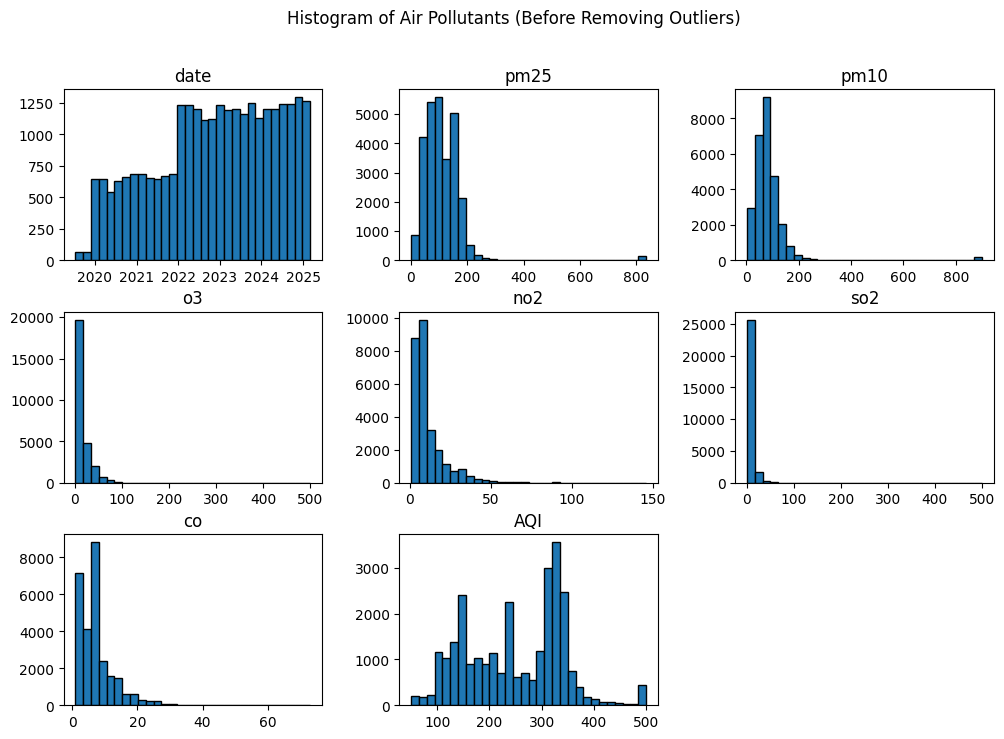

In [24]:

df.hist(figsize=(12, 8), bins=30, grid=False, edgecolor='black')
plt.suptitle('Histogram of Air Pollutants (Before Removing Outliers)')
plt.show()



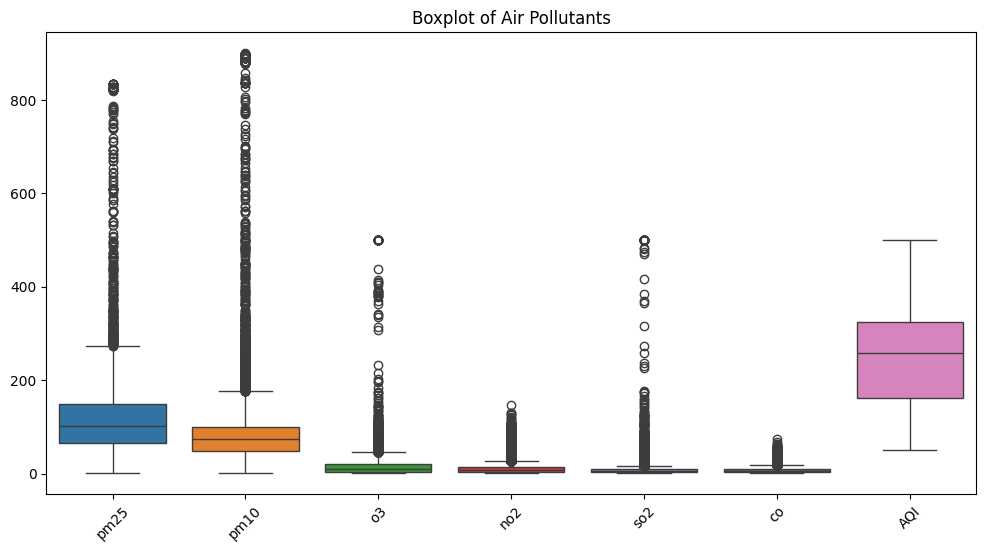

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title('Boxplot of Air Pollutants')
plt.show()


In [26]:


# List of pollutant columns
pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']

# Function to remove outliers using IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply function to remove outliers
df_cleaned = remove_outliers(df, pollutants)

# Print shape before & after
print(f"Original Data Shape: {df.shape}")
print(f"Cleaned Data Shape: {df_cleaned.shape}")


Original Data Shape: (27798, 9)
Cleaned Data Shape: (19746, 9)


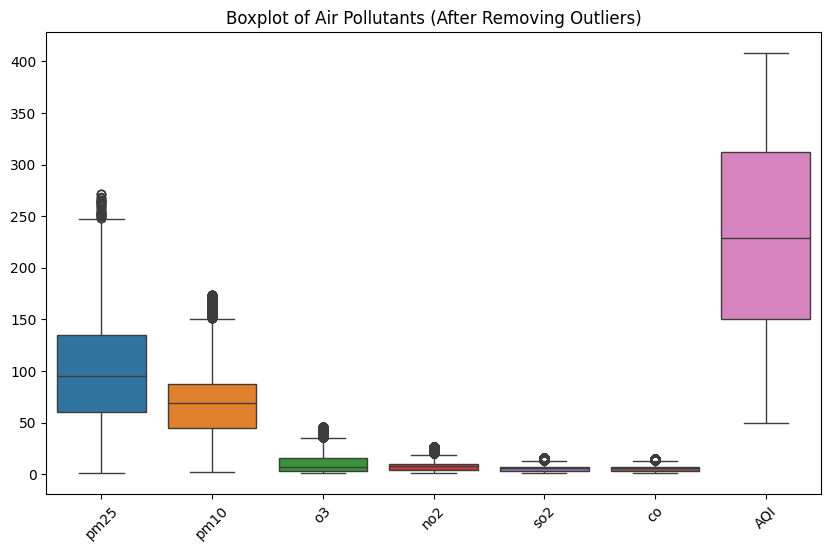

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned)
plt.xticks(rotation=45)
plt.title('Boxplot of Air Pollutants (After Removing Outliers)')
plt.show()

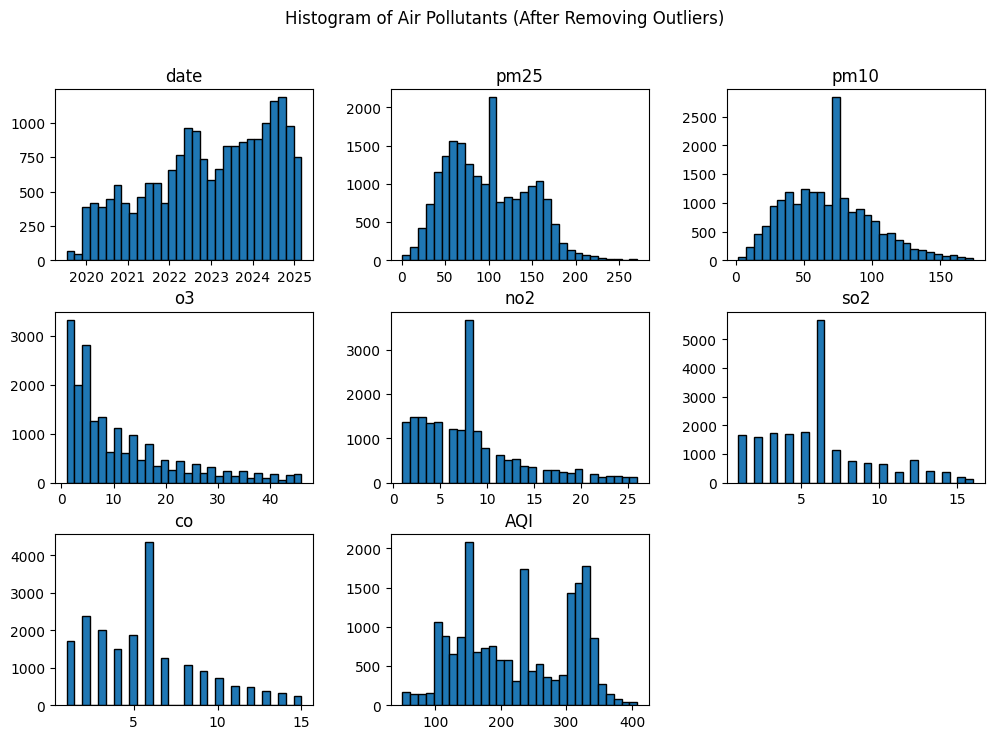

In [28]:
df_cleaned.hist(figsize=(12, 8), bins=30, grid=False, edgecolor='black')
plt.suptitle('Histogram of Air Pollutants (After Removing Outliers)')
plt.show()


Recalculating AQI (After Removing Outliers)

In [30]:
def calculate_aqi(row):
    # Define AQI breakpoints (Based on CPCB India AQI standards)
    breakpoints = {
        'pm25': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300), (121, 250, 301, 400), (251, 500, 401, 500)],
        'pm10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300), (351, 430, 301, 400), (431, 600, 401, 500)],
        'no2':  [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), (181, 280, 201, 300), (281, 400, 301, 400), (401, 1000, 401, 500)],
        'so2':  [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200), (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 2000, 401, 500)],
        'co':   [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200), (10.1, 17, 201, 300), (17.1, 34, 301, 400), (34.1, 50, 401, 500)]
    }

    def calculate_pollutant_aqi(value, pollutant):
        for bp in breakpoints[pollutant]:
            if bp[0] <= value <= bp[1]:
                return ((bp[3] - bp[2]) / (bp[1] - bp[0])) * (value - bp[0]) + bp[2]
        return None  # If value is out of range

    aqi_values = []
    for pollutant in ['pm25', 'pm10', 'no2', 'so2', 'co']:
        if not pd.isna(row[pollutant]):  # Ensure value is present
            aqi = calculate_pollutant_aqi(row[pollutant], pollutant)
            if aqi is not None:
                aqi_values.append(aqi)

    return max(aqi_values) if aqi_values else None  # Highest AQI among pollutants

# Apply the AQI calculation
df_cleaned['AQI'] = df_cleaned.apply(calculate_aqi, axis=1)


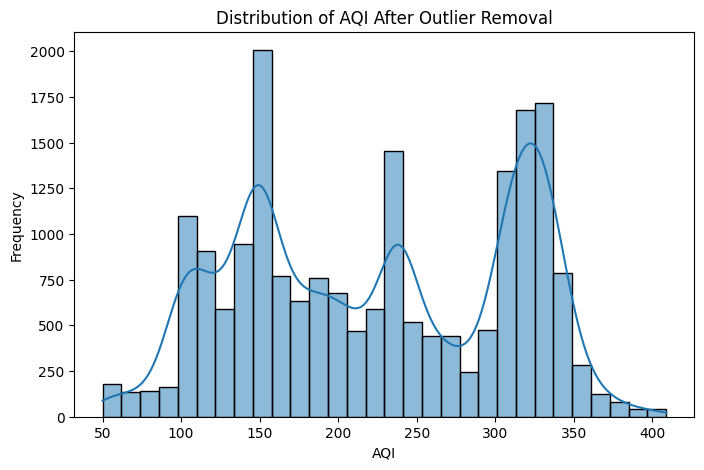

In [31]:
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['AQI'].dropna(), bins=30, kde=True)
plt.title("Distribution of AQI After Outlier Removal")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.show()

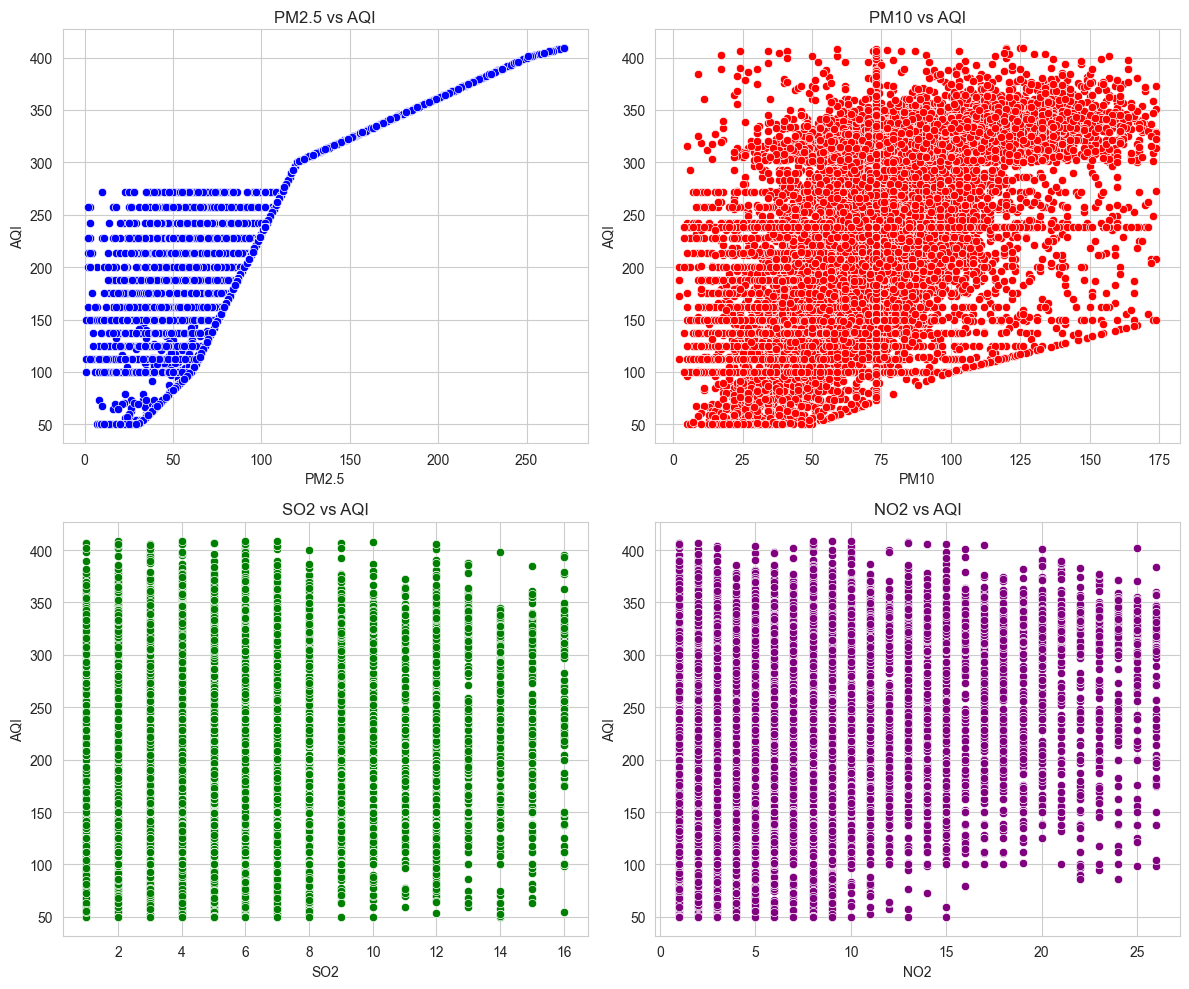

In [32]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure with subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plots
sns.scatterplot(x=df_cleaned['pm25'], y=df_cleaned['AQI'], ax=axes[0, 0], color="blue")
axes[0, 0].set_title("PM2.5 vs AQI")
axes[0, 0].set_xlabel("PM2.5")
axes[0, 0].set_ylabel("AQI")

sns.scatterplot(x=df_cleaned['pm10'], y=df_cleaned['AQI'], ax=axes[0, 1], color="red")
axes[0, 1].set_title("PM10 vs AQI")
axes[0, 1].set_xlabel("PM10")
axes[0, 1].set_ylabel("AQI")

sns.scatterplot(x=df_cleaned['so2'], y=df_cleaned['AQI'], ax=axes[1, 0], color="green")
axes[1, 0].set_title("SO2 vs AQI")
axes[1, 0].set_xlabel("SO2")
axes[1, 0].set_ylabel("AQI")

sns.scatterplot(x=df_cleaned['no2'], y=df_cleaned['AQI'], ax=axes[1, 1], color="purple")
axes[1, 1].set_title("NO2 vs AQI")
axes[1, 1].set_xlabel("NO2")
axes[1, 1].set_ylabel("AQI")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

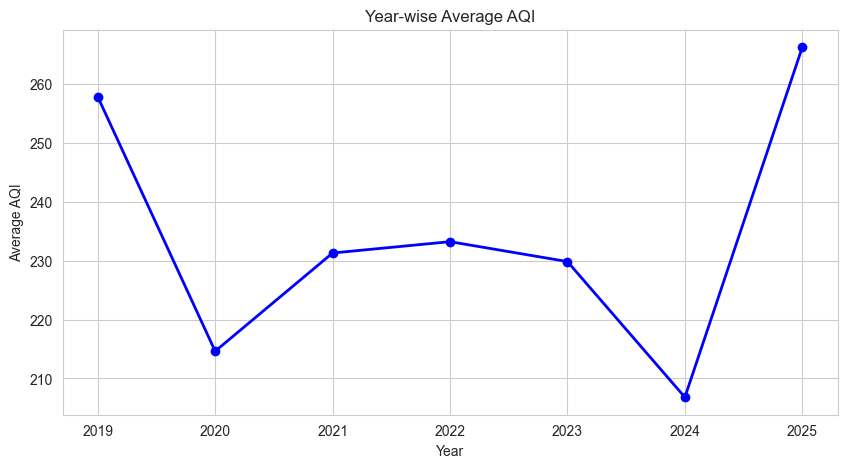

In [33]:
df_cleaned['year'] = df_cleaned['date'].dt.year

# Group by year and calculate mean AQI
yearly_aqi = df_cleaned.groupby('year')['AQI'].mean()

# Plot year-wise average AQI
plt.figure(figsize=(10, 5))
plt.plot(yearly_aqi.index, yearly_aqi.values, marker='o', linestyle='-', color='b', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Average AQI")
plt.title("Year-wise Average AQI")
plt.grid(True)
plt.show()

In [34]:
df_cleaned[['pm25', 'pm10', 'so2', 'no2', 'AQI']].corr()


,pm25,pm10,so2,no2,AQI
pm25,1.000000,0.625777,0.001294,0.260215,0.928778
pm10,0.625777,1.000000,0.092265,0.284280,0.597977
so2,0.001294,0.092265,1.000000,0.106333,0.010313
no2,0.260215,0.284280,0.106333,1.000000,0.265117
AQI,0.928778,0.597977,0.010313,0.265117,1.000000


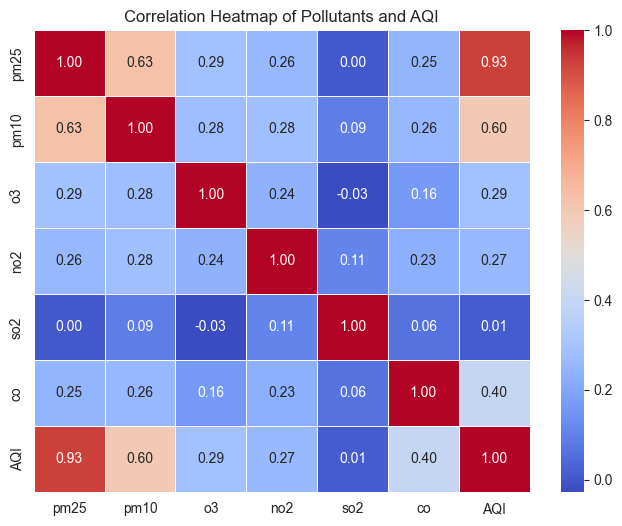

In [35]:
corr_matrix = df_cleaned[['pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'AQI']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Pollutants and AQI")
plt.show()

In [36]:
# Group by Station and calculate the average AQI
station_avg_aqi = df_cleaned.groupby("Station_Name")["AQI"].mean().reset_index()

# Sort by AQI in descending order
highest_aqi_station = station_avg_aqi.sort_values(by="AQI", ascending=False).head(10)  # Top 10 stations
print(highest_aqi_station)


               Station_Name         AQI
12                  Mazgaon  258.706236
5                    Deonar  252.214662
15    Siddharth Nagar Worli  243.813330
7                Khadakpada  241.507554
2      Chakala Andheri East  239.081120
11               Malad West  238.229119
8   Khindipada Bhandup West  235.883266
17               Vasai West  232.362884
18          Vile Parle West  230.919543
10                   Mahape  228.862888


C:\Users\arvin\AppData\Local\Temp\ipykernel_22932\3156049363.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=highest_aqi_station, x="AQI", y="Station_Name", palette="Reds_r")


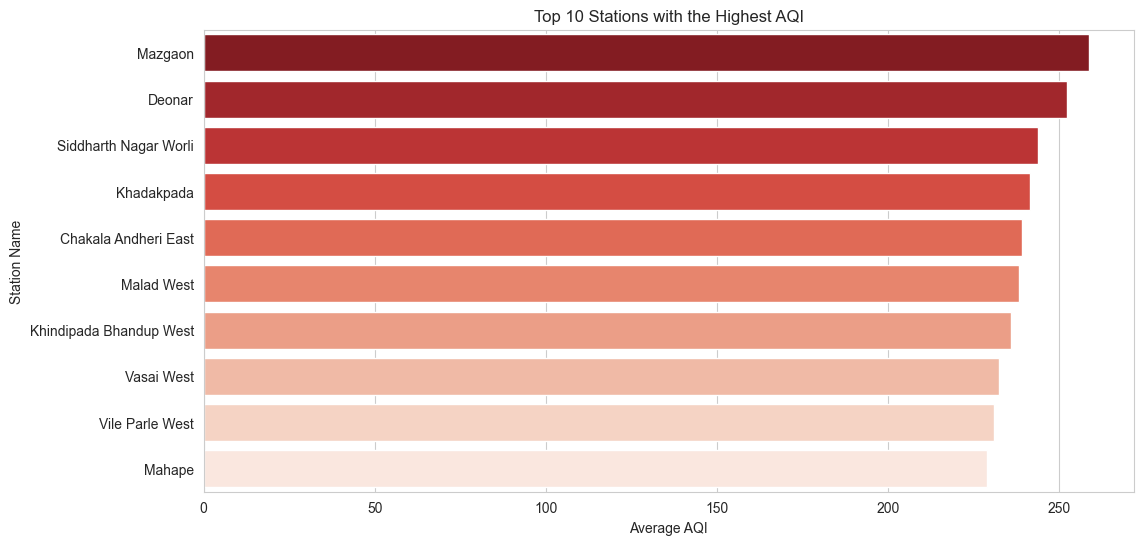

In [37]:
plt.figure(figsize=(12,6))
sns.barplot(data=highest_aqi_station, x="AQI", y="Station_Name", palette="Reds_r")
plt.xlabel("Average AQI")
plt.ylabel("Station Name")
plt.title("Top 10 Stations with the Highest AQI")
plt.show()

In [38]:
df_cleaned["date"] = pd.to_datetime(df_cleaned["date"])  # Ensure correct datetime format
df_cleaned["month"] = df_cleaned["date"].dt.month        # Extract month

monthly_station_aqi = df_cleaned.groupby(["Station_Name", "month"])["AQI"].mean().reset_index()


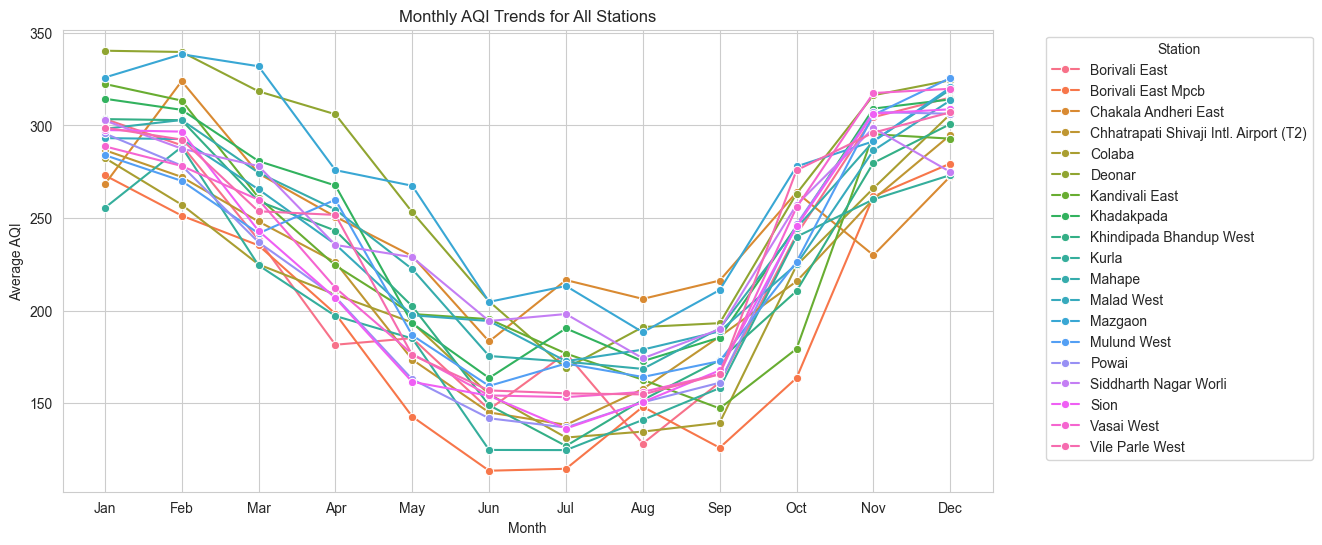

In [39]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_station_aqi, x="month", y="AQI", hue="Station_Name", marker="o")

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Month labels
plt.xlabel("Month")
plt.ylabel("Average AQI")
plt.title("Monthly AQI Trends for All Stations")
plt.legend(title="Station", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside the plot
plt.grid(True)
plt.show()

In [40]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19746 entries, 0 to 27797
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          19746 non-null  datetime64[ns]
 1   pm25          19746 non-null  float64       
 2   pm10          19746 non-null  float64       
 3   o3            19746 non-null  float64       
 4   no2           19746 non-null  float64       
 5   so2           19746 non-null  float64       
 6   co            19746 non-null  float64       
 7   Station_Name  19746 non-null  object        
 8   AQI           19746 non-null  float64       
 9   year          19746 non-null  int32         
 10  month         19746 non-null  int32         
dtypes: datetime64[ns](1), float64(7), int32(2), object(1)
memory usage: 1.7+ MB


In [41]:
# Features (Independent Variables)
X = df_cleaned[['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']]  

# Target Variable (AQI)
y = df_cleaned['AQI']


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [44]:
y_pred = xgb_model.predict(X_test)


In [45]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')


MAE: 0.2996480843466213
MSE: 0.7808259858057567
RMSE: 0.8836435852795835
R² Score: 0.9998919535292727


<Figure size 800x500 with 0 Axes>

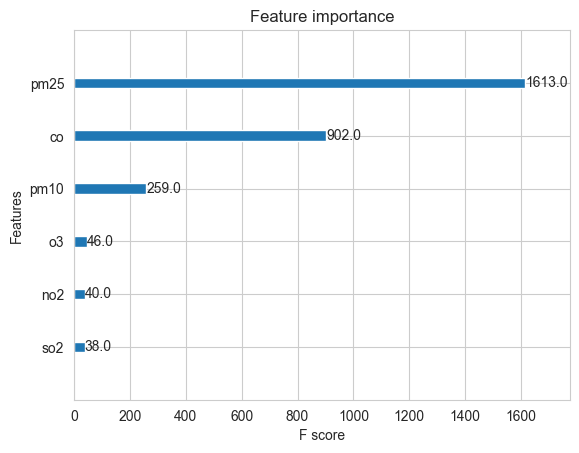

In [46]:

plt.figure(figsize=(8,5))
xgb.plot_importance(xgb_model, importance_type="weight")
plt.show()

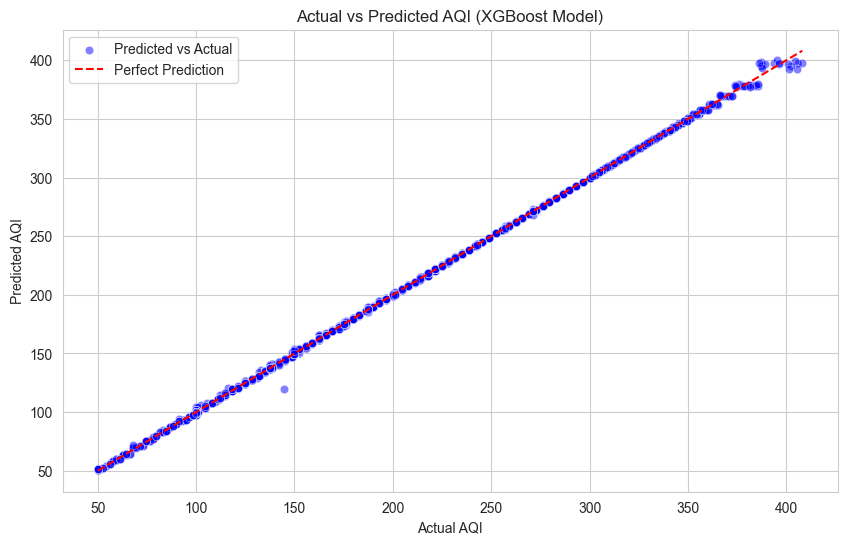

In [47]:
plt.figure(figsize=(10, 6))

# Scatter plot for actual vs predicted
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='blue', label="Predicted vs Actual")

# 45-degree line for reference
max_val = max(max(y_test), max(y_pred))  
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI (XGBoost Model)")
plt.legend()
plt.show()

R² Score (Linear Regression): 0.8936


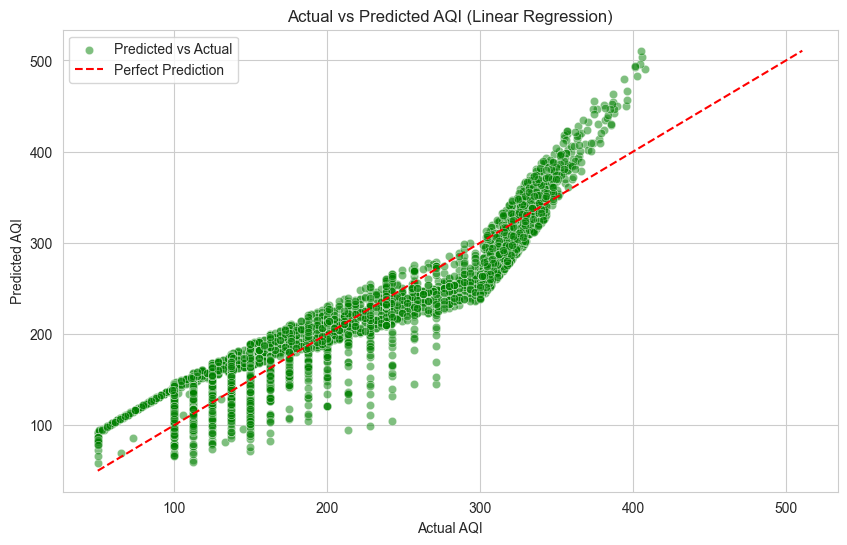

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Predict AQI values
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
r2_lr = r2_score(y_test, y_pred_lr)
print(f"R² Score (Linear Regression): {r2_lr:.4f}")

# Visualization of Actual vs Predicted AQI
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.5, color='green', label="Predicted vs Actual")

# 45-degree reference line
max_val = max(max(y_test), max(y_pred_lr))
min_val = min(min(y_test), min(y_pred_lr))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI (Linear Regression)")
plt.legend()
plt.show()


In [49]:

# Calculate R² Score for Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R² Score: {r2_lr:.4f}")



Linear Regression R² Score: 0.8936


In [50]:
print(f'R² Score: {r2}')

R² Score: 0.9998919535292727
